# nnInteractive Environment Setup and Demo

Before running this notebook, ensure you've activated the nnInteractive conda environment using the following commands in your terminal:

```bash
source /software/anaconda3/etc/profile.d/conda.sh
conda activate nnInteractive
```

Or select the nnInteractive kernel when opening this notebook.

In [1]:
# Verify environment is properly activated
import sys
import os

# Print Python environment information
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")

# Check if environment contains nnInteractive
try:
    import nnInteractive
    print(f"nnInteractive version: {nnInteractive.__version__ if hasattr(nnInteractive, '__version__') else 'Unknown'}")
    print("✅ nnInteractive successfully imported")
except ImportError:
    print("❌ nnInteractive not found in this environment!")

Python version: 3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:56:27) [GCC 11.2.0]
Python executable: /software/anaconda3/envs/nnInteractive/bin/python
nnInteractive version: Unknown
✅ nnInteractive successfully imported


In [7]:
# Import dependencies commonly used with nnInteractive
import torch
import SimpleITK as sitk
import numpy as np
import matplotlib
matplotlib.use('Agg')  # Set non-interactive backend
import matplotlib.pyplot as plt
%matplotlib inline 

# Check GPU availability
if torch.cuda.is_available():
    print(f"✅ GPU available: {torch.cuda.get_device_name(0)}")
    print(f"   CUDA Version: {torch.version.cuda}")
else:
    print("❌ No GPU detected. nnInteractive will run on CPU (may be slow)")

✅ GPU available: NVIDIA RTX A4000
   CUDA Version: 12.6


## Initialize nnInteractive Session

The following cells demonstrate how to initialize a nnInteractive inference session and prepare it for use.

In [3]:
# Define paths
MODEL_NAME = "nnInteractive_v1.0"
DOWNLOAD_DIR = "/nfs/norasys/notebooks/camaret/model_checkpoints"
IMAGE_FILENAME = "/nfs/data/nii/data1/Analysis/GPUnet/ANALYSIS_incontext/amos22/amos22/imagesVa/amos_0311.nii.gz"

# Initialize the session
from nnInteractive.inference.inference_session import nnInteractiveInferenceSession

session = nnInteractiveInferenceSession(
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    use_torch_compile=False,
    verbose=True,  # Set to True to see additional information
    torch_n_threads=os.cpu_count(),
    do_autozoom=True,
    use_pinned_memory=True
)

# Load the trained model
model_path = os.path.join(DOWNLOAD_DIR, MODEL_NAME)
session.initialize_from_trained_model_folder(model_path)

print(f"✅ nnInteractive session initialized from {model_path}")

nnUNet_raw is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
nnUNet_results is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.
✅ nnInteractive session initialized from /nfs/norasys/notebooks/camaret/model_checkpoints/nnInteractive_v1.0


Loaded image with shape: (1, 198, 512, 512)


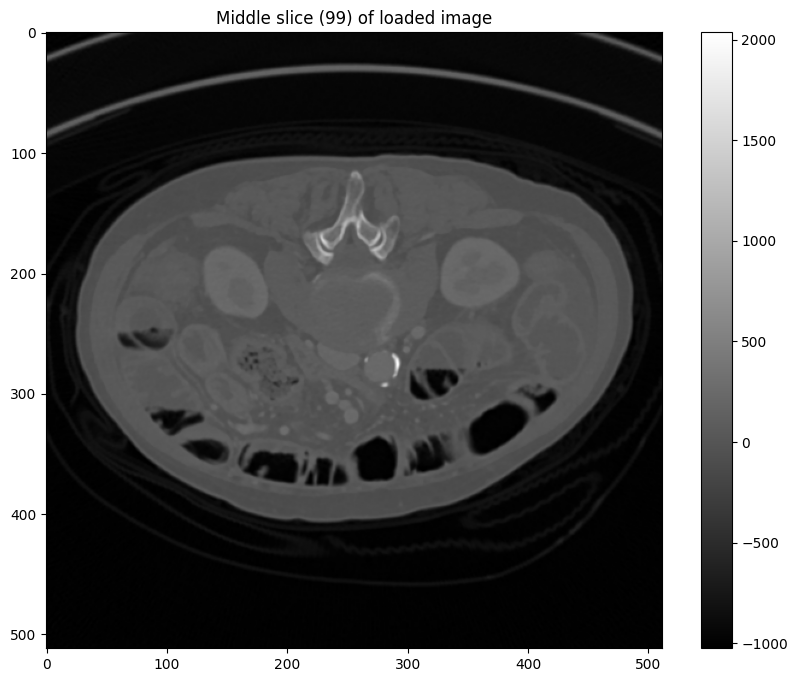

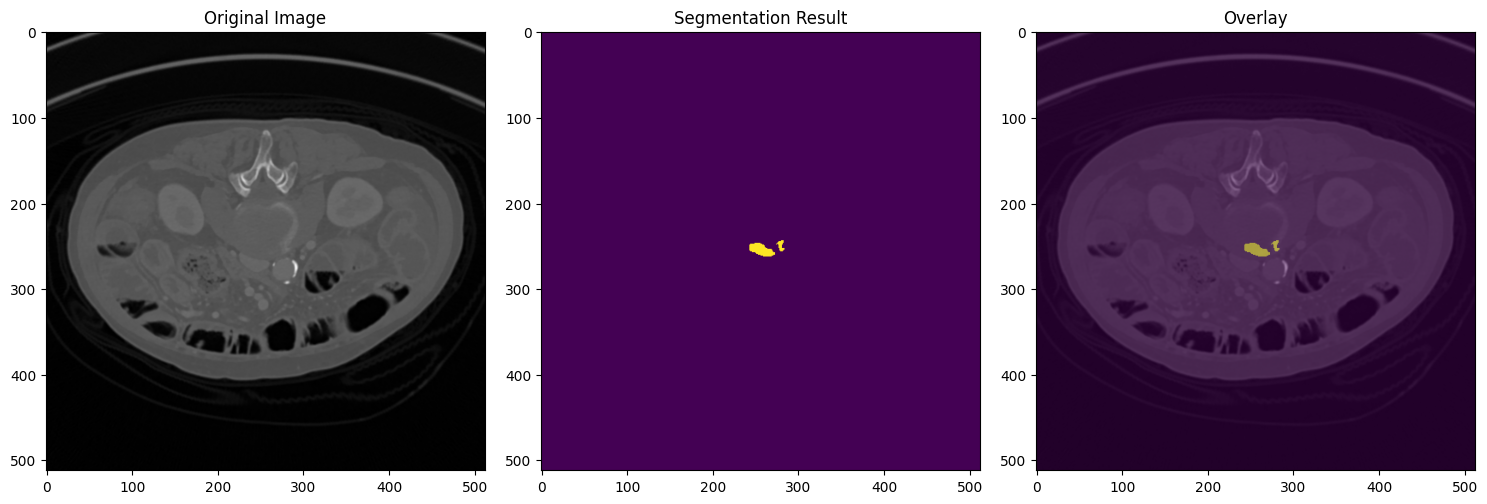

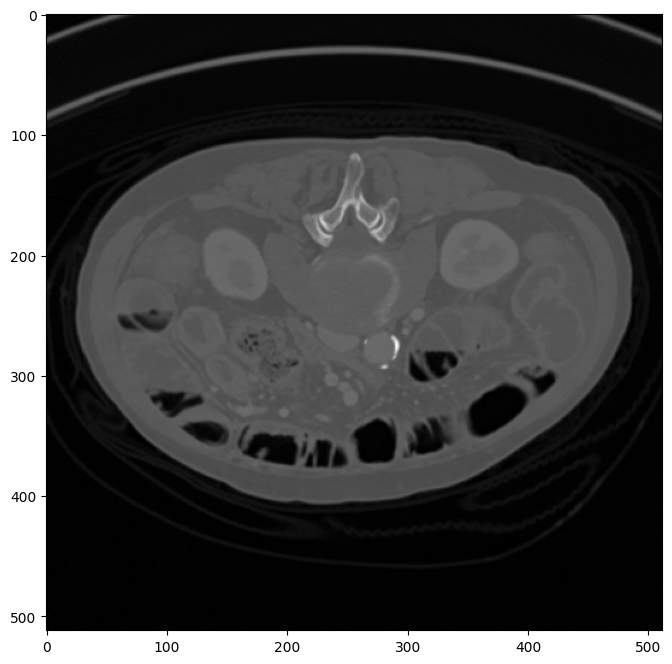

In [ ]:
# Load and prepare input image
input_image = sitk.ReadImage(IMAGE_FILENAME)
img = sitk.GetArrayFromImage(input_image)[None]  # Ensure shape (1, x, y, z)

print(f"Loaded image with shape: {img.shape}")

# Visualize a middle slice
middle_slice = img.shape[1] // 2
#plt.style.use("default")

plt.figure(figsize=(10, 8))
plt.imshow(img[0, middle_slice], cmap='gray')
#plt.title(f"Middle slice ({middle_slice}) of loaded image")
#plt.colorbar()
plt.show()

In [5]:
# Set up the session with the input image
session.set_image(img)

# Create output buffer
target_tensor = torch.zeros(img.shape[1:], dtype=torch.uint8)
session.set_target_buffer(target_tensor)

# Add a point interaction (adjust coordinates based on your image)
point_coords = (middle_slice, img.shape[2]//2, img.shape[3]//2)
print(f"Adding point interaction at: {point_coords}")
session.add_point_interaction(point_coords, include_interaction=True)

# Get results
results = session.target_buffer.clone()

# Show the segmentation result
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(131)
plt.title("Original Image")
plt.imshow(img[0, point_coords[0]], cmap='gray')

# Segmentation result
plt.subplot(132)
plt.title("Segmentation Result")
plt.imshow(results[point_coords[0]], cmap='viridis')

# Overlay
plt.subplot(133)
plt.title("Overlay")
plt.imshow(img[0, point_coords[0]], cmap='gray')
plt.imshow(results[point_coords[0]], cmap='viridis', alpha=0.5)

plt.tight_layout()
plt.show()

Initialize with raw image shape (1, 198, 512, 512)
Adding point interaction at: (99, 256, 256)
Cropping input image to nonzero region
Cropped image shape: torch.Size([1, 198, 512, 512])
Initialize interactions. Pinned: True
Normalizing cropped image
Pin memory: image
Added new point interaction: center 1, scale [[99, 256, 256]]
Performing prediction at zoom out factor 1
Auto zoom stage took 1.416s. Max zoom out factor was 1
No refinement necessary
Done. Total time 1.419s


/tmp/ipykernel_1453/3496217411.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


## Helper Functions

Here are some helpful functions for working with medical images in this environment.

In [6]:
def resize_preserve_content(arr, target_shape):
    """Resize array to target shape using interpolation to preserve all content."""
    from scipy.ndimage import zoom
    
    # Calculate zoom factors for each dimension
    factors = [t/s for t, s in zip(target_shape, arr.shape)]
    
    # Apply zoom with interpolation
    return zoom(arr, factors, order=1)

def visualize_volume(volume, num_slices=16, cmap='gray'):
    """Visualize multiple slices of a 3D volume"""
    plt.figure(figsize=(12, 12))
    rows, cols = 4, 4
    step = max(1, volume.shape[0] // num_slices)
    
    for i in range(min(num_slices, rows*cols)):
        slice_idx = min(i * step, volume.shape[0]-1)
        plt.subplot(rows, cols, i+1)
        plt.imshow(volume[slice_idx], cmap=cmap)
        plt.title(f"Slice {slice_idx}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## Additional Resources

For more information on using nnInteractive, refer to the documentation and examples in the codebase directory:

```
/nfs/norasys/notebooks/camaret
```